<a href="https://colab.research.google.com/github/Zephyruss1/Zephyruss1/blob/main/Review_classification_activeLR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import plotly.express as px
import re
import string
import warnings
warnings.filterwarnings('ignore')
tfds.disable_progress_bar()

In [ ]:
dataset = tfds.load(
    'imdb_reviews',
    split='train+test',
    as_supervised=True,
    batch_size=-1,
    shuffle_files=False
)
reviews, labels = tfds.as_numpy(dataset)
print('Total examples:', reviews.shape[0])

Total examples: 50000


In [ ]:
# import pandas as pd
# def show_missing_values(data):
#   missing_data = data.isna().sum()
#   missing_data_percent = data.isna().sum() / len(data)
#   print("Duplicated data: ", data.duplicated().sum())
#   result = pd.concat([missing_data, missing_data_percent], axis=1)
#   result.columns = ['Missing Count', 'Missing Percent']
#   return result

# show_missing_values(dataset)

"""
Not worked because data packed with tuples.
"""

'\nNot worked because data packed with tuples.\n'

## Data PreProcessing

In [ ]:
val_split   = 2500
test_split  = 2500
train_split = 7500

# Separating the negative and positive samples for manual stratification
x_positives, y_positives = reviews[labels == 1], labels[labels == 1]
x_negatives, y_negatives = reviews[labels == 0], labels[labels == 0]

# Creating training, validation and testing splits
x_val, y_val = (
    tf.concat(
        (
            x_positives[:val_split], x_negatives[:val_split]

        ),
        0
    ),
    tf.concat(
        (
            y_positives[:val_split], y_negatives[:val_split]
        ),
        0
    )
)
x_test, y_test = (
    tf.concat(
        (
            x_positives[val_split : val_split + test_split],
            x_negatives[val_split : val_split + test_split]
        ),
        0
    ),
    tf.concat(
        (
            y_positives[val_split : val_split + test_split],
            y_negatives[val_split : val_split + test_split]
        ),
        0
    ,
    )
)
x_train, y_train = (
    tf.concat(
        (
            x_positives[val_split + test_split : val_split + test_split + train_split],
            x_negatives[val_split + test_split : val_split + test_split + train_split]
        ),
        0
    ),
    tf.concat(
        (
            y_positives[val_split + test_split : val_split + test_split + train_split],
            y_negatives[val_split + test_split : val_split + test_split + train_split]
        ),
        0
    )
)
x_pool_positives, y_pool_positives = (
    x_positives[val_split + test_split + train_split :],
    y_positives[val_split + test_split + train_split :]
)
x_pool_negatives, y_pool_negatives = (
    x_negatives[val_split + test_split + train_split :],
    y_negatives[val_split + test_split + train_split :]
)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_dataset   = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test_dataset  = tf.data.Dataset.from_tensor_slices((x_test, y_test))

pool_negatives = tf.data.Dataset.from_tensor_slices(
    (x_pool_negatives, y_pool_negatives)
)

pool_positives = tf.data.Dataset.from_tensor_slices(
    (x_pool_positives, y_pool_positives)
)
print(f"Initial training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Testing set size: {len(test_dataset)}")
print(f"Unlabeled negative set size: {len(pool_negatives)}")
print(f"Unlabeled positives set size: {len(pool_positives)}")

Initial training set size: 15000
Validation set size: 5000
Testing set size: 5000
Unlabeled negative set size: 12500
Unlabeled positives set size: 12500


## Standardization and WORD2VEC

In [ ]:
# Custom standardization
def standardization(data):
  lowercase = tf.strings.lower(data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(
      stripped_html, f"[{re.escape(string.punctuation)}]", ""
  )

vectorizer = layers.TextVectorization(3000, standardize=standardization, output_sequence_length=150)
vectorizer.adapt(train_dataset.map(lambda x, y: x, num_parallel_calls=tf.data.AUTOTUNE).batch(256))

# WORD2VEC
def vectorize_text(text, label):
  text = vectorizer(text)
  return text, label

# Vectrize --> train,test, val, pool negatives & positives datasets.
train_dataset = train_dataset.map(
    vectorize_text, num_parallel_calls=tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)

pool_negatives = pool_negatives.map(vectorize_text, num_parallel_calls=tf.data.AUTOTUNE)
pool_positives = pool_positives.map(vectorize_text, num_parallel_calls=tf.data.AUTOTUNE)

val_dataset = val_dataset.batch(256).map(
    vectorize_text, num_parallel_calls=tf.data.AUTOTUNE
)
test_dataset = test_dataset.batch(256).map(
    vectorize_text, num_parallel_calls=tf.data.AUTOTUNE
)

## Helper Functions

In [ ]:
def append_history(losses, val_losses, accuracy, val_accuracy, history):
  losses = losses + history.history['loss']
  val_losses = val_losses + history.history['val_loss']
  accuracy = accuracy + history.history['binary_accuracy']
  val_accuracy = val_accuracy + history.history['val_binary_accuracy']
  return losses, val_losses, accuracy, val_accuracy

# Plot
def plot_history(losses, val_losses, accuracies, val_accuracies):
    fig = plt.figure()
    fig.set_facecolor('black')
    plt.plot(losses)
    plt.plot(val_losses)
    plt.legend(["train_loss", "val_loss"])
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

    plt.plot(accuracies)
    plt.plot(val_accuracies)
    plt.legend(["train_accuracy", "val_accuracy"])
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.show()


In [ ]:
def create_model():
  model = keras.models.Sequential(
      [
          layers.Input(shape=(150,)),
          layers.Embedding(input_dim=3000, output_dim=128),
          layers.Bidirectional(layers.LSTM(32, return_sequences=True)),
          layers.GlobalMaxPooling1D(),
          layers.Dense(20, activation='relu'),
          layers.Dropout(0.25),
          layers.Dense(1, activation='sigmoid')
      ]
  )
  model.summary()
  return model

## Training Model

In [ ]:
def train_full_model(full_train_dataset, val_dataset, test_dataset):
  model = create_model()
  model.compile(
      loss='binary_crossentropy',
      optimizer='rmsprop',
      metrics=[
        keras.metrics.BinaryAccuracy(),
        keras.metrics.FalseNegatives(),
        keras.metrics.FalsePositives(),
      ],
  )

  history = model.fit(
      full_train_dataset.batch(256),
      epochs=20, # Train round
      validation_data=val_dataset,
      callbacks=[
          keras.callbacks.EarlyStopping(patience=4),
          keras.callbacks.ModelCheckpoint( # Save best turn in model.
              'FullModelCheckpoint.h5', save_best_only=True
          ),
      ],
  )


  model = keras.models.load_model('FullModelCheckpoint.h5')
  print('-' * 100)
  print("test set evaluation: ", model.evaluate(test_dataset, return_dict=True))
  print('-' * 100)
  return model

full_train_dataset=(
    train_dataset.concatenate(pool_positives).concatenate(pool_negatives).cache().shuffle(20000)
)

full_dataset_model = train_full_model(full_train_dataset, val_dataset, test_dataset)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 150, 128)          384000    
                                                                 
 bidirectional_5 (Bidirecti  (None, 150, 64)           41216     
 onal)                                                           
                                                                 
 global_max_pooling1d_5 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_10 (Dense)            (None, 20)                1300      
                                                                 
 dropout_5 (Dropout)         (None, 20)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                

1) False Negatives / All False Predictions

2) False Positives / All False Predictions

## Training via Active Learning

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 150, 128)          384000    
                                                                 
 bidirectional_7 (Bidirecti  (None, 150, 64)           41216     
 onal)                                                           
                                                                 
 global_max_pooling1d_7 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_14 (Dense)            (None, 20)                1300      
                                                                 
 dropout_7 (Dropout)         (None, 20)                0         
                                                                 
 dense_15 (Dense)            (None, 1)                

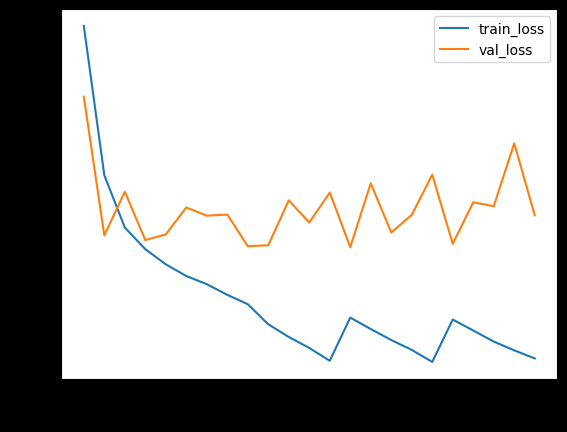

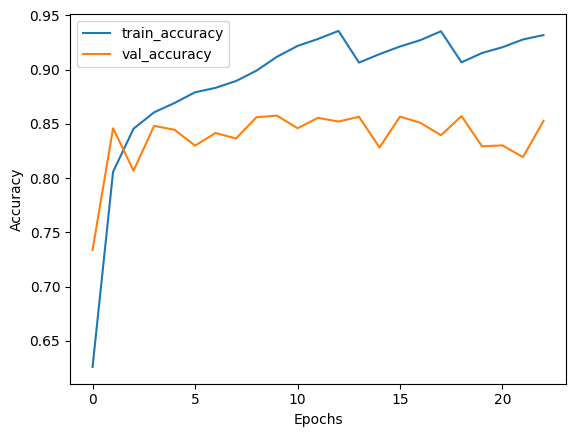

----------------------------------------------------------------------------------------------------
Test set evaluation:  {'loss': 0.3508985638618469, 'binary_accuracy': 0.8550000190734863, 'false_negatives_9': 398.0, 'false_positives_9': 327.0}
----------------------------------------------------------------------------------------------------


In [ ]:
def train_active_learning_models(
    train_dataset,
    pool_negatives,
    pool_positives,
    val_dataset,
    test_dataset,
    num_iterations=3,
    sampling_size=5000
):
    losses, val_losses, accuracies, val_accuracies = [], [], [], []

    model = create_model()

    model.compile(
        loss='binary_crossentropy',
        optimizer='rmsprop',
        metrics=[
        keras.metrics.BinaryAccuracy(),
        keras.metrics.FalseNegatives(),
        keras.metrics.FalsePositives(),
        ],
    )

    checkpoint = keras.callbacks.ModelCheckpoint(
        'AL_Model.h5', save_best_only=True
    )
    early_stopping = keras.callbacks.EarlyStopping(patience=4)

    print(f"Starting to train with {len(train_dataset)} samples")

    history = model.fit(
    full_train_dataset.shuffle(20000).batch(256),
    epochs=20, # Train round
    validation_data=val_dataset,
    callbacks=[
        checkpoint,
        early_stopping
      ],
    )

    losses, val_losses, accuracies, val_accuracies = append_history(
         losses, val_losses, accuracies, val_accuracies, history
    )

    for iteration in range(num_iterations):
      predictions = model.predict(test_dataset)

      rounded = tf.where(tf.greater(predictions, 0.5), 1, 0)

      _, _, false_negatives, false_positives = model.evaluate(test_dataset)

      print("-" * 100)
      print(
          f"Number of zeros incorrectly classified: {false_negatives}, Number of ones incorrectly classified: {false_positives}"
      )

      if false_negatives != 0 and false_positives !=0:
        total = false_positives + false_positives
        sample_ratio_ones, sample_ratio_zeros = (
            false_positives / total,
            false_negatives / total,
        )

      else:
        sample_ratio_ones, sample_ratio_zeros = 0.5, 0.5
      print(
          f"Sample ratio for positives: {sample_ratio_ones}, Sample ratio for negatives:{sample_ratio_zeros}"
          )
      sampled_dataset = pool_negatives.take(
          int(sample_ratio_zeros * sampling_size)
      ).concatenate(pool_positives.take(int(sample_ratio_ones * sampling_size)))

      pool_negatives = pool_negatives.skip(int(sample_ratio_zeros * sampling_size))
      pool_positives = pool_positives.skip(int(sample_ratio_ones * sampling_size))

      train_dataset = train_dataset.concatenate(sampled_dataset).prefetch(tf.data.AUTOTUNE)
      print(f"Starting training with {len(train_dataset)} samples")
      print("-" * 100)

      model.compile(
            loss="binary_crossentropy",
            optimizer="rmsprop",
            metrics=[
                keras.metrics.BinaryAccuracy(),
                keras.metrics.FalseNegatives(),
                keras.metrics.FalsePositives(),
            ],
        )

      history = model.fit(
          train_dataset.cache().shuffle(20000).batch(256),
          validation_data=val_dataset,
          epochs=20,
          callbacks=[
              checkpoint,
              keras.callbacks.EarlyStopping(patience=4, verbose=1),
          ],
      )
      losses, val_losses, accuracies, val_accuracies = append_history(
            losses, val_losses, accuracies, val_accuracies, history
        )

        # Loading the best model from this training loop
      model = keras.models.load_model("AL_Model.h5")
    plot_history(losses, val_losses, accuracies, val_accuracies)
    print("-" * 100)
    print(
        "Test set evaluation: ",
        model.evaluate(test_dataset, verbose=0, return_dict=True),
    )
    print("-" * 100)
    return model
active_learning_model = train_active_learning_models(
    train_dataset, pool_negatives, pool_positives, val_dataset, test_dataset
)